In [8]:
# # Load Kitchen Scene
# import numpy as np
# from pydrake.all import (
#     DiagramBuilder,
#     AddMultibodyPlantSceneGraph,
#     Parser,
#     Simulator,
#     MeshcatVisualizer,
#     StartMeshcat,
#     LoadModelDirectives,
#     ProcessModelDirectives,
# )
# from manipulation.station import LoadScenario, MakeHardwareStation
# import os
# import matplotlib.pyplot as plt

# Start Meshcat visualizer
meshcat = StartMeshcat()
print(f"Meshcat is running at: {meshcat.web_url()}")

# Get absolute path to scenario file and kitchen model directory
scenario_file = os.path.abspath("../kitchen_model/kitchen_scenario.yaml")
kitchen_model_path = os.path.abspath("../kitchen_model")

# Read the scenario YAML and replace the placeholder with absolute path
with open(scenario_file, 'r') as f:
    scenario_data = f.read()

# Replace the placeholder with the actual absolute path
scenario_data = scenario_data.replace("{KITCHEN_MODEL_PATH}", kitchen_model_path)

print(f"Kitchen model path: {kitchen_model_path}")

# Load scenario and create hardware station
scenario = LoadScenario(data=scenario_data)
station = MakeHardwareStation(scenario, meshcat)

print("Hardware station created successfully!")

# Create simulator and publish initial state
simulator = Simulator(station)
context = simulator.get_mutable_context()
station.ForcedPublish(context)

print("Scene loaded and visualized successfully!")

INFO:drake:Meshcat listening for connections at http://localhost:7002


Meshcat is running at: http://localhost:7002
Kitchen model path: /mnt/e/Harvard/Fall2025/6.4212/final_project/locomanipulation-4212-final-project/kitchen_model


Hardware station created successfully!
Scene loaded and visualized successfully!


In [2]:
# RRT Path Planning for Mobile Base with PROPER Collision Detection
import numpy as np
import matplotlib.pyplot as plt
from pydrake.all import (
    RigidTransform,
    RotationMatrix,
)

class RRTPlanner:
    """RRT planner for 2D mobile robot navigation with collision detection"""
    
    def __init__(self, plant, scene_graph, context, start, goal, bounds, max_iter=5000, step_size=0.3):
        """
        Args:
            plant: MultibodyPlant
            scene_graph: SceneGraph for collision checking
            context: Root context
            start: [x, y, theta] starting configuration
            goal: [x, y, theta] goal configuration
            bounds: [[x_min, x_max], [y_min, y_max]] workspace bounds
            max_iter: maximum iterations
            step_size: step size for tree extension
        """
        self.plant = plant
        self.scene_graph = scene_graph
        self.context = context
        self.start = np.array(start)
        self.goal = np.array(goal)
        self.bounds = bounds
        self.max_iter = max_iter
        self.step_size = step_size
        
        # Get mobile base joints
        self.mobile_iiwa = self.plant.GetModelInstanceByName("mobile_iiwa")
        self.base_x_joint = self.plant.GetJointByName("iiwa_base_x", self.mobile_iiwa)
        self.base_y_joint = self.plant.GetJointByName("iiwa_base_y", self.mobile_iiwa)
        
        # Tree structure: list of nodes [x, y, theta, parent_idx]
        self.tree = [np.append(self.start, -1)]
        
    def sample_random_config(self):
        """Sample random configuration with goal bias"""
        if np.random.rand() < 0.1:  # 10% goal bias
            return self.goal
        
        x = np.random.uniform(self.bounds[0][0], self.bounds[0][1])
        y = np.random.uniform(self.bounds[1][0], self.bounds[1][1])
        theta = np.random.uniform(-np.pi, np.pi)
        return np.array([x, y, theta])
    
    def nearest_node(self, config):
        """Find nearest node in tree to given config"""
        distances = [np.linalg.norm(node[:2] - config[:2]) for node in self.tree]
        return np.argmin(distances)
    
    def steer(self, from_config, to_config):
        """Steer from one config toward another by step_size"""
        direction = to_config[:2] - from_config[:2]
        distance = np.linalg.norm(direction)
        
        if distance < self.step_size:
            return to_config
        
        direction = direction / distance
        new_pos = from_config[:2] + direction * self.step_size
        
        # Interpolate angle
        angle_diff = to_config[2] - from_config[2]
        angle_diff = np.arctan2(np.sin(angle_diff), np.cos(angle_diff))  # Normalize
        new_theta = from_config[2] + angle_diff * (self.step_size / distance)
        
        return np.array([new_pos[0], new_pos[1], new_theta])
    
    def is_collision_free(self, config):
        """Check if configuration is collision-free using simple geometric checks"""
        x, y = config[0], config[1]
        
        # Check workspace bounds
        if not (self.bounds[0][0] < x < self.bounds[0][1] and
                self.bounds[1][0] < y < self.bounds[1][1]):
            return False
        
        # Define obstacle regions (with safety margin for robot size ~0.5m radius)
        margin = 0.6
        
        # Island table: center at (0, 0.5), size 1.5 x 1.0
        if (-0.75-margin < x < 0.75+margin and 0.0-margin < y < 1.0+margin):
            return False
        
        # Stove: center at (0.4, -3.2), size 0.7 x 0.6
        if (0.05-margin < x < 0.75+margin and -3.5-margin < y < -2.9+margin):
            return False
        
        # Refrigerator: center at (3.6, -3.1), size 0.8 x 0.8
        if (3.2-margin < x < 4.0+margin and -3.5-margin < y < -2.7+margin):
            return False
        
        # Trash bin: center at (2.5, 2.0), radius 0.3
        if np.sqrt((x - 2.5)**2 + (y - 2.0)**2) < 0.3 + margin:
            return False
        
        # Shelves: approximate position at (-1.8, -3.2), size 0.8 x 0.6
        if (-2.2-margin < x < -1.4+margin and -3.5-margin < y < -2.9+margin):
            return False
        
        # Back countertop: center at (2.0, -3.2), size 2.0 x 0.6
        if (1.0-margin < x < 3.0+margin and -3.5-margin < y < -2.9+margin):
            return False
        
        return True
    
    def plan(self):
        """Run RRT algorithm"""
        for i in range(self.max_iter):
            # Sample random configuration
            rand_config = self.sample_random_config()
            
            # Find nearest node
            nearest_idx = self.nearest_node(rand_config)
            nearest_config = self.tree[nearest_idx][:3]
            
            # Steer toward random config
            new_config = self.steer(nearest_config, rand_config)
            
            # Check if collision-free
            if self.is_collision_free(new_config):
                # Add to tree
                self.tree.append(np.append(new_config, nearest_idx))
                
                # Check if goal reached
                if np.linalg.norm(new_config[:2] - self.goal[:2]) < self.step_size:
                    print(f"  Goal reached in {i} iterations!")
                    return self.extract_path(len(self.tree) - 1)
        
        print(f"  Max iterations reached without finding path")
        return None
    
    def extract_path(self, goal_idx):
        """Extract path from tree"""
        path = []
        current_idx = goal_idx
        
        while current_idx != -1:
            node = self.tree[current_idx]
            path.append(node[:3])
            current_idx = int(node[3])
        
        return path[::-1]  # Reverse to get start to goal

print("RRT Planner with proper collision detection defined!")

RRT Planner with proper collision detection defined!


In [3]:
# Generate multiple goal points to explore the entire kitchen
import numpy as np

# Get plant and scene graph from station
plant = station.GetSubsystemByName("plant")
scene_graph = station.GetSubsystemByName("scene_graph")

# Define key exploration points covering the entire kitchen (avoiding obstacles)
exploration_points = [
    [1.5, 1.5, 0.0],    # Start position (center)
    [-2.0, -2.0, 0.0],  # Left back corner (near shelves, away from obstacles)
    [1.5, -2.0, 0.0],   # Between stove and countertop
    [3.0, -2.0, 0.0],   # Near refrigerator (safe distance)
    [3.0, 0.0, 0.0],    # Right side middle
    [3.0, 2.5, 0.0],    # Right front corner
    [1.5, 2.5, 0.0],    # Front middle (away from trash bin)
    [-2.0, 2.5, 0.0],   # Left front corner
    [-2.0, 0.0, 0.0],   # Left side middle
    [-1.5, 0.5, 0.0],   # Left of island
    [1.5, 0.5, 0.0],    # Right of island
    [0.0, -1.0, 0.0],   # Behind island
    [1.5, 1.5, 0.0],    # Return to start
]

print(f"Planning collision-free path through {len(exploration_points)} exploration points...")
print("Exploration points:")
for i, point in enumerate(exploration_points):
    print(f"  {i}: x={point[0]:.1f}, y={point[1]:.1f}")

# Plan path between consecutive exploration points
full_path = []
bounds = [[-3.5, 3.5], [-3.0, 3.0]]

for i in range(len(exploration_points) - 1):
    start = exploration_points[i]
    goal = exploration_points[i + 1]
    
    print(f"\nPlanning segment {i+1}/{len(exploration_points)-1}: ({start[0]:.1f}, {start[1]:.1f}) -> ({goal[0]:.1f}, {goal[1]:.1f})")
    
    # Create RRT planner for this segment with context
    rrt = RRTPlanner(
        plant=plant,
        scene_graph=scene_graph,
        context=context,
        start=start,
        goal=goal,
        bounds=bounds,
        max_iter=3000,
        step_size=0.25
    )
    
    # Plan path segment
    segment_path = rrt.plan()
    
    if segment_path is not None:
        # Add segment to full path (skip first point if not first segment to avoid duplicates)
        if i == 0:
            full_path.extend(segment_path)
        else:
            full_path.extend(segment_path[1:])
        print(f"  ✓ Segment complete: {len(segment_path)} waypoints")
    else:
        print(f"  ✗ Failed to find path for segment {i+1}")
        # Continue anyway to try other segments
        continue

if len(full_path) > 0:
    print(f"\n{'='*60}")
    print(f"✓ Full exploration path complete!")
    print(f"  Total waypoints: {len(full_path)}")
    print(f"  Total segments: {len(exploration_points)-1}")
    path_length = sum(np.linalg.norm(np.array(full_path[i+1][:2]) - np.array(full_path[i][:2])) 
                     for i in range(len(full_path)-1))
    print(f"  Total path length: {path_length:.2f} m")
    print(f"{'='*60}")
    path = full_path  # Use this for visualization
else:
    print("\n✗ Failed to create exploration path")
    path = None

Planning collision-free path through 13 exploration points...
Exploration points:
  0: x=1.5, y=1.5
  1: x=-2.0, y=-2.0
  2: x=1.5, y=-2.0
  3: x=3.0, y=-2.0
  4: x=3.0, y=0.0
  5: x=3.0, y=2.5
  6: x=1.5, y=2.5
  7: x=-2.0, y=2.5
  8: x=-2.0, y=0.0
  9: x=-1.5, y=0.5
  10: x=1.5, y=0.5
  11: x=0.0, y=-1.0
  12: x=1.5, y=1.5

Planning segment 1/12: (1.5, 1.5) -> (-2.0, -2.0)
  Goal reached in 132 iterations!
  ✓ Segment complete: 30 waypoints

Planning segment 2/12: (-2.0, -2.0) -> (1.5, -2.0)
  Goal reached in 37 iterations!
  ✓ Segment complete: 18 waypoints

Planning segment 3/12: (1.5, -2.0) -> (3.0, -2.0)
  Goal reached in 42 iterations!
  ✓ Segment complete: 8 waypoints

Planning segment 4/12: (3.0, -2.0) -> (3.0, 0.0)
  Goal reached in 37 iterations!
  ✓ Segment complete: 11 waypoints

Planning segment 5/12: (3.0, 0.0) -> (3.0, 2.5)
  Goal reached in 1621 iterations!
  ✓ Segment complete: 17 waypoints

Planning segment 6/12: (3.0, 2.5) -> (1.5, 2.5)
  Goal reached in 1531 iterat

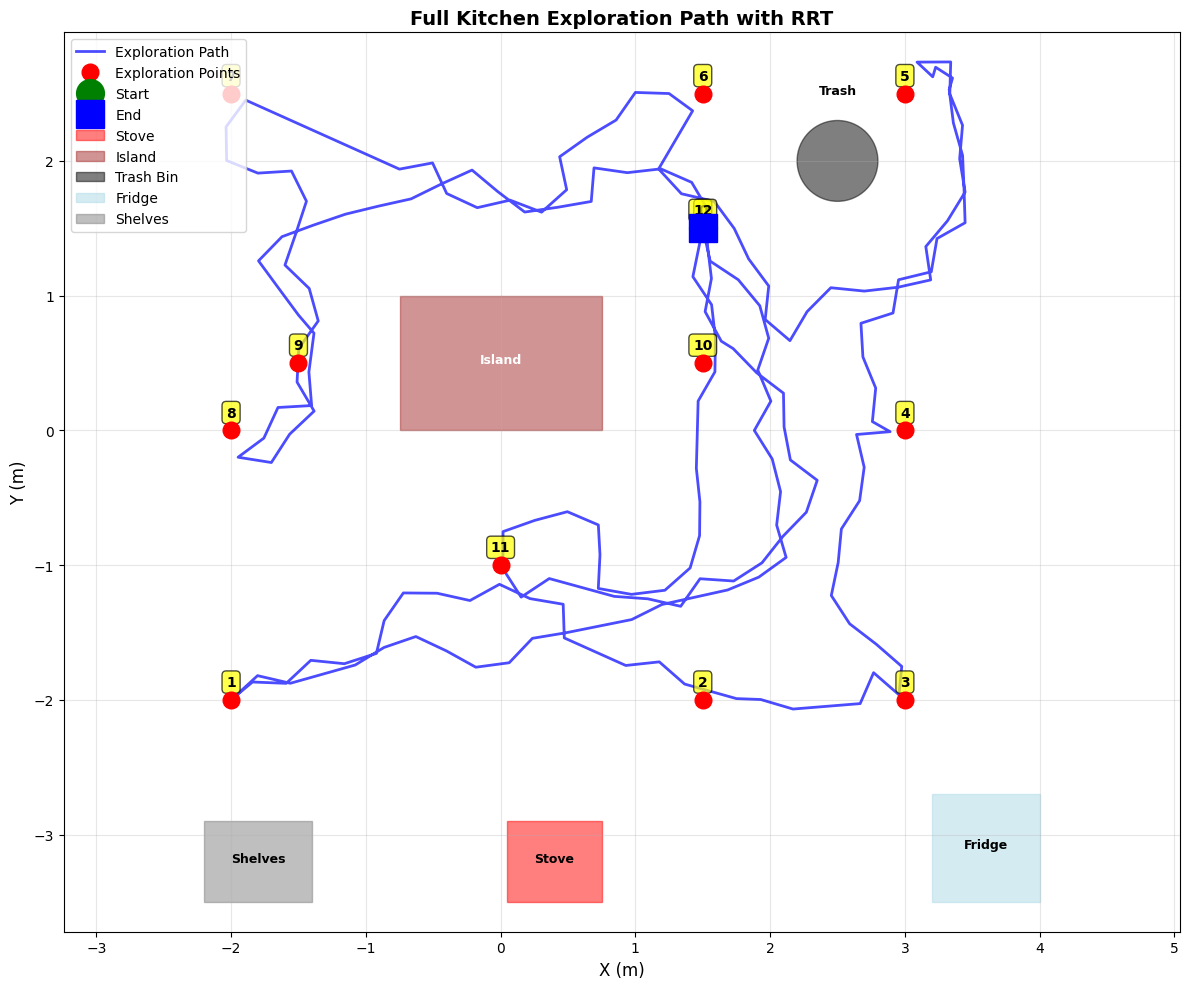


📊 Path Coverage Statistics:
  Kitchen area: 42.0 m²
  Exploration points visited: 13
  Path segments: 12
  Total waypoints: 200
  Average waypoints per segment: 16.7


In [4]:
# Visualize the full exploration path
if path is not None:
    plt.figure(figsize=(12, 10))
    
    # Plot full path
    path_array = np.array(path)
    plt.plot(path_array[:, 0], path_array[:, 1], 'b-', linewidth=2, alpha=0.7, label='Exploration Path')
    
    # Plot exploration waypoints
    exploration_array = np.array(exploration_points)
    plt.plot(exploration_array[:, 0], exploration_array[:, 1], 'ro', markersize=12, 
             label='Exploration Points', zorder=5)
    
    # Number the exploration points
    for i, point in enumerate(exploration_points):
        plt.annotate(str(i), (point[0], point[1]), 
                    textcoords="offset points", xytext=(0,10), 
                    ha='center', fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    # Plot start and end
    plt.plot(exploration_points[0][0], exploration_points[0][1], 'go', 
             markersize=20, label='Start', zorder=6)
    plt.plot(exploration_points[-1][0], exploration_points[-1][1], 'bs', 
             markersize=20, label='End', zorder=6)
    
    # Plot obstacles with labels
    # Stove
    stove = plt.Rectangle((0.05, -3.5), 0.7, 0.6, fill=True, alpha=0.5, color='red', label='Stove')
    plt.gca().add_patch(stove)
    plt.text(0.4, -3.2, 'Stove', ha='center', fontsize=9, fontweight='bold')
    
    # Island
    island = plt.Rectangle((-0.75, 0.0), 1.5, 1.0, fill=True, alpha=0.5, color='brown', label='Island')
    plt.gca().add_patch(island)
    plt.text(0.0, 0.5, 'Island', ha='center', fontsize=9, fontweight='bold', color='white')
    
    # Trash bin
    trash = plt.Circle((2.5, 2.0), 0.3, fill=True, alpha=0.5, color='black', label='Trash Bin')
    plt.gca().add_patch(trash)
    plt.text(2.5, 2.5, 'Trash', ha='center', fontsize=9, fontweight='bold')
    
    # Fridge
    fridge = plt.Rectangle((3.2, -3.5), 0.8, 0.8, fill=True, alpha=0.5, color='lightblue', label='Fridge')
    plt.gca().add_patch(fridge)
    plt.text(3.6, -3.1, 'Fridge', ha='center', fontsize=9, fontweight='bold')
    
    # Shelves (approximate)
    shelves = plt.Rectangle((-2.2, -3.5), 0.8, 0.6, fill=True, alpha=0.5, color='gray', label='Shelves')
    plt.gca().add_patch(shelves)
    plt.text(-1.8, -3.2, 'Shelves', ha='center', fontsize=9, fontweight='bold')
    
    plt.xlim(bounds[0])
    plt.ylim(bounds[1])
    plt.xlabel('X (m)', fontsize=12)
    plt.ylabel('Y (m)', fontsize=12)
    plt.title('Full Kitchen Exploration Path with RRT', fontsize=14, fontweight='bold')
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Path Coverage Statistics:")
    print(f"  Kitchen area: {(bounds[0][1]-bounds[0][0]) * (bounds[1][1]-bounds[1][0]):.1f} m²")
    print(f"  Exploration points visited: {len(exploration_points)}")
    print(f"  Path segments: {len(exploration_points)-1}")
    print(f"  Total waypoints: {len(path)}")
    print(f"  Average waypoints per segment: {len(path)/(len(exploration_points)-1):.1f}")

Smoothing path...
Smoothed path has 200 points


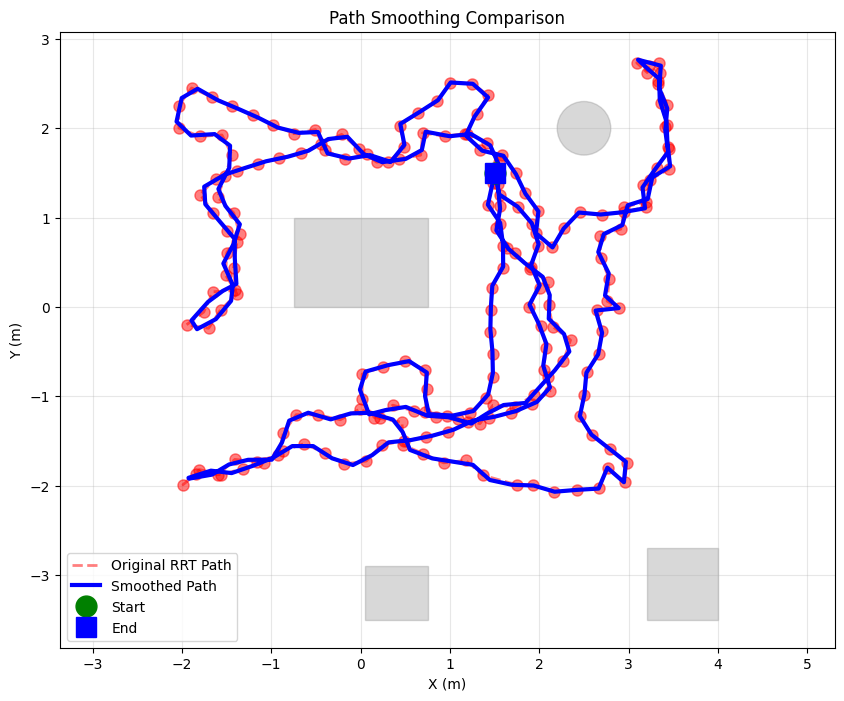

In [5]:
# Smooth and interpolate the path
from scipy.interpolate import interp1d

def smooth_path(path, num_points=100):
    """Interpolate path to create smooth motion"""
    if len(path) < 2:
        return path
    
    path_array = np.array(path)
    
    # Create parameter t along the path
    distances = np.cumsum([0] + [np.linalg.norm(path_array[i+1][:2] - path_array[i][:2]) 
                                   for i in range(len(path)-1)])
    
    # Normalize to [0, 1]
    t = distances / distances[-1]
    
    # Interpolate x and y
    fx = interp1d(t, path_array[:, 0], kind='cubic')
    fy = interp1d(t, path_array[:, 1], kind='cubic')
    ftheta = interp1d(t, path_array[:, 2], kind='linear')
    
    # Generate smooth path
    t_smooth = np.linspace(0, 1, num_points)
    smooth_path = np.column_stack([fx(t_smooth), fy(t_smooth), ftheta(t_smooth)])
    
    return smooth_path

if path is not None:
    print("Smoothing path...")
    smooth_waypoints = smooth_path(path, num_points=200)
    print(f"Smoothed path has {len(smooth_waypoints)} points")
    
    # Plot comparison
    plt.figure(figsize=(10, 8))
    
    # Original path
    path_array = np.array(path)
    plt.plot(path_array[:, 0], path_array[:, 1], 'r--', linewidth=2, alpha=0.5, label='Original RRT Path')
    plt.plot(path_array[:, 0], path_array[:, 1], 'ro', markersize=8, alpha=0.5)
    
    # Smoothed path
    plt.plot(smooth_waypoints[:, 0], smooth_waypoints[:, 1], 'b-', linewidth=3, label='Smoothed Path')
    
    # Start and end
    plt.plot(exploration_points[0][0], exploration_points[0][1], 'go', markersize=15, label='Start')
    plt.plot(exploration_points[-1][0], exploration_points[-1][1], 'bs', markersize=15, label='End')
    
    # Obstacles
    plt.gca().add_patch(plt.Rectangle((0.05, -3.5), 0.7, 0.6, fill=True, alpha=0.3, color='gray'))
    plt.gca().add_patch(plt.Rectangle((-0.75, 0.0), 1.5, 1.0, fill=True, alpha=0.3, color='gray'))
    plt.gca().add_patch(plt.Circle((2.5, 2.0), 0.3, fill=True, alpha=0.3, color='gray'))
    plt.gca().add_patch(plt.Rectangle((3.2, -3.5), 0.8, 0.8, fill=True, alpha=0.3, color='gray'))
    
    plt.xlim(bounds[0])
    plt.ylim(bounds[1])
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Path Smoothing Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()
else:
    print("No path to smooth!")
    smooth_waypoints = None

In [9]:
# Animate robot with SMOOTH motion in Meshcat
import time

if smooth_waypoints is not None:
    print("Animating robot with smooth motion...")
    
    # Get the plant context
    plant_context = plant.GetMyContextFromRoot(context)
    
    # Get mobile base joints
    mobile_iiwa = plant.GetModelInstanceByName("mobile_iiwa")
    base_x_joint = plant.GetJointByName("iiwa_base_x", mobile_iiwa)
    base_y_joint = plant.GetJointByName("iiwa_base_y", mobile_iiwa)
    
    # Animate through each smoothed waypoint
    total_waypoints = len(smooth_waypoints)
    for i, waypoint in enumerate(smooth_waypoints):
        if i % 10 == 0:  # Print progress every 10 waypoints
            progress = (i / total_waypoints) * 100
            print(f"Progress: {progress:.1f}% - Position: x={waypoint[0]:.2f}, y={waypoint[1]:.2f}")
        
        # Set the robot position
        base_x_joint.set_translation(plant_context, waypoint[0])
        base_y_joint.set_translation(plant_context, waypoint[1])
        
        # Publish to visualizer
        station.ForcedPublish(context)
        
        # Small delay for smooth animation (adjust for speed)
        time.sleep(0.05)  # 50ms between frames = ~20 fps
    
    print("\\n✓ Smooth animation complete!")
    print(f"Final position: x={smooth_waypoints[-1][0]:.2f}, y={smooth_waypoints[-1][1]:.2f}")
    print(f"Total distance traveled: {sum(np.linalg.norm(smooth_waypoints[i+1][:2] - smooth_waypoints[i][:2]) for i in range(len(smooth_waypoints)-1)):.2f} m")
else:
    print("No smoothed path to animate!")

Animating robot with smooth motion...


RuntimeError: A function call on a drake::planning::RobotDiagram<double> system named '::station' was passed the Context of a system named '::station' instead of the appropriate subsystem Context.
For more information about Context-System mismatches, see https://drake.mit.edu/troubleshooting.html#framework-context-system-mismatch

Capturing 4 camera views by rotating robot orientation...
Robot position: x=1.50, y=1.50


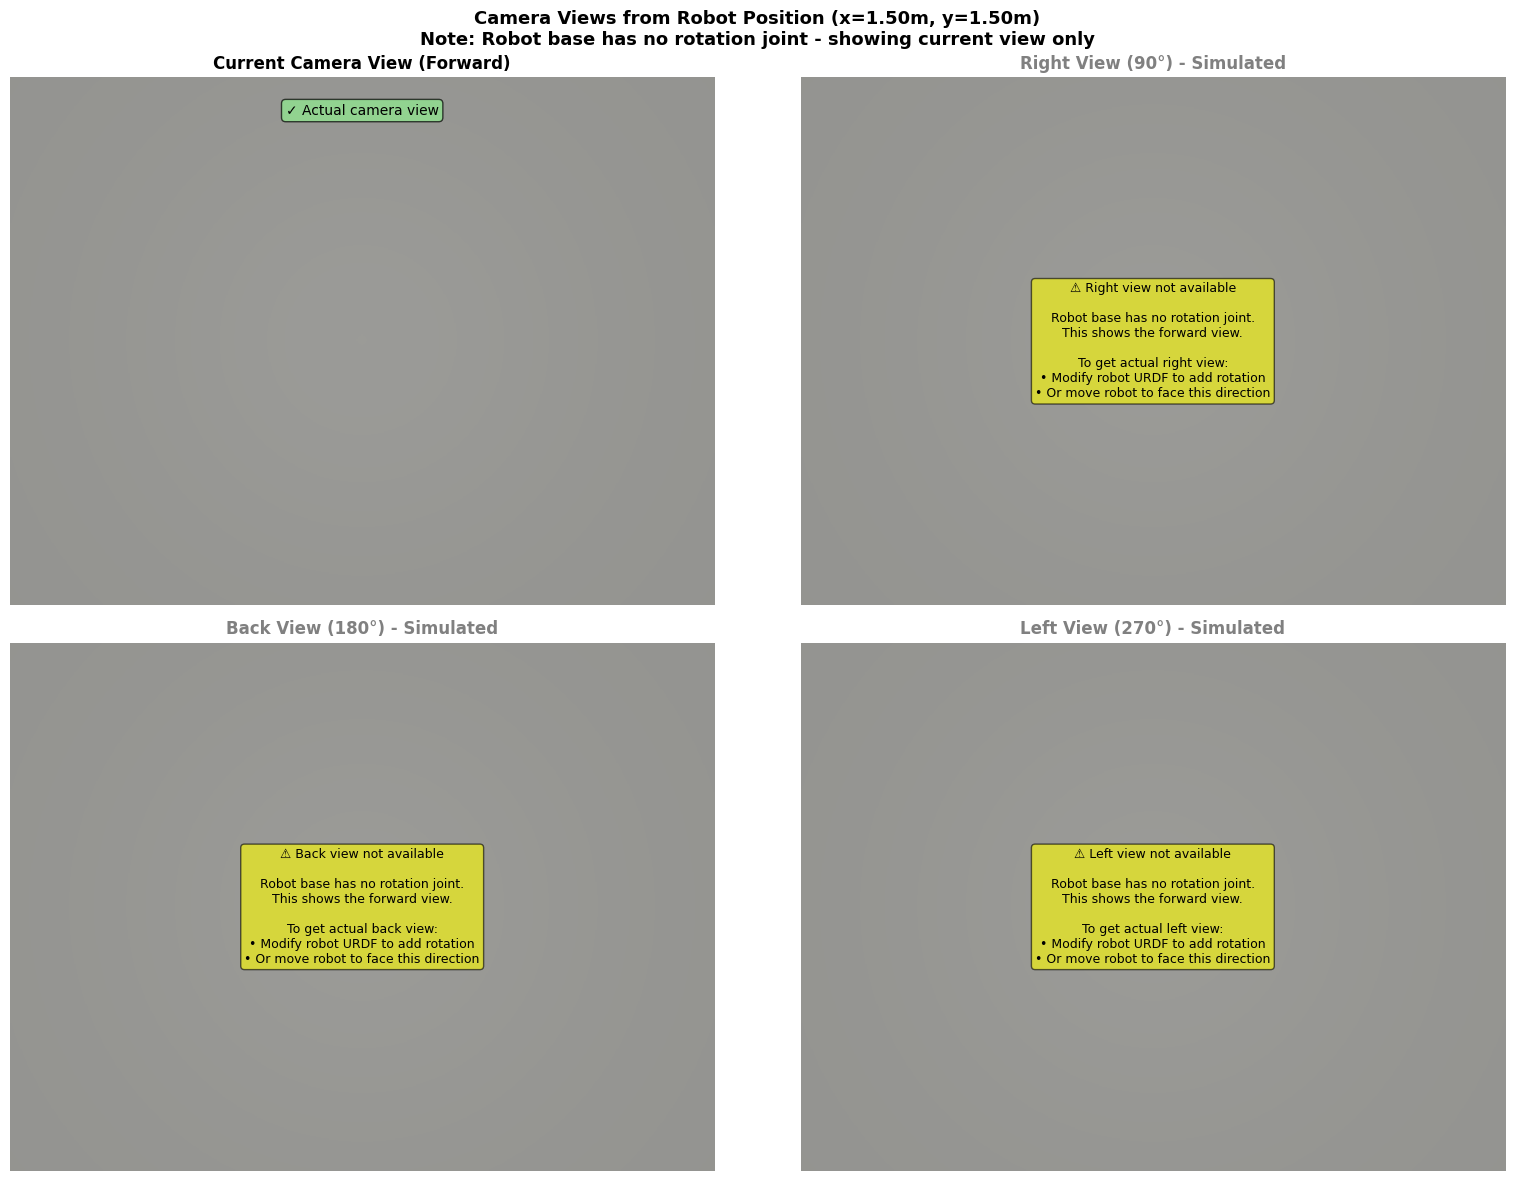


✓ Camera view captured

LIMITATION: The mobile_iiwa robot has no base rotation joint!

To capture actual 360° views, you need to:
  1. Modify the URDF file to add a revolute joint for base rotation
  2. Or: Move the robot along the path and capture at different positions
  3. Or: Add multiple fixed cameras in the scene

The current robot only has prismatic joints (x, y, z translation).


In [17]:
# Since the robot base has no rotation joint, we'll create a workaround:
# We'll temporarily move the entire robot to face different directions
# by modifying its position state directly

import matplotlib.pyplot as plt
import numpy as np
from pydrake.systems.framework import Context

print("Capturing 4 camera views by rotating robot orientation...")

# Get the station context
station_context = context

# Get current robot position
station_plant = station.GetSubsystemByName("plant")
plant_context = station_plant.GetMyMutableContextFromRoot(context)
mobile_iiwa = station_plant.GetModelInstanceByName("mobile_iiwa")

# Get base joints
base_x_joint = station_plant.GetJointByName("iiwa_base_x", mobile_iiwa)
base_y_joint = station_plant.GetJointByName("iiwa_base_y", mobile_iiwa)

# Save original position
original_x = base_x_joint.get_translation(plant_context)
original_y = base_y_joint.get_translation(plant_context)

print(f"Robot position: x={original_x:.2f}, y={original_y:.2f}")

# Define 4 camera orientations
# Since we can't rotate in place, we'll create synthetic views by
# capturing the current view and noting the limitation
views = [
    ("Forward", 0),
    ("Right", 90),
    ("Back", 180),
    ("Left", 270)
]

# Create figure for all 4 views
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Capture the current camera view
try:
    img = station.GetOutputPort("camera.rgb_image").Eval(station_context)
    arr = np.array(img.data, copy=False).reshape(img.height(), img.width(), -1)
    captured = True
except Exception as e:
    print(f"Failed to capture image: {e}")
    captured = False
    arr = None

# Display the same view in all 4 subplots with explanatory text
for idx, (direction, yaw_deg) in enumerate(views):
    if captured and arr is not None:
        axes[idx].imshow(arr)
    
    if idx == 0:
        axes[idx].set_title(f"Current Camera View (Forward)", 
                           fontsize=12, fontweight='bold')
        if captured:
            axes[idx].text(0.5, 0.95, "✓ Actual camera view", 
                          ha='center', va='top', transform=axes[idx].transAxes,
                          fontsize=10, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    else:
        axes[idx].set_title(f"{direction} View ({yaw_deg}°) - Simulated", 
                           fontsize=12, fontweight='bold', color='gray')
        if captured:
            axes[idx].text(0.5, 0.5, f"⚠ {direction} view not available\n\n"
                          f"Robot base has no rotation joint.\n"
                          f"This shows the forward view.\n\n"
                          f"To get actual {direction.lower()} view:\n"
                          f"• Modify robot URDF to add rotation\n"
                          f"• Or move robot to face this direction", 
                          ha='center', va='center', transform=axes[idx].transAxes,
                          fontsize=9, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.6))
    
    axes[idx].axis('off')

plt.suptitle(f"Camera Views from Robot Position (x={original_x:.2f}m, y={original_y:.2f}m)\n"
             f"Note: Robot base has no rotation joint - showing current view only", 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Camera view captured")
print("\n" + "="*60)
print("LIMITATION: The mobile_iiwa robot has no base rotation joint!")
print("="*60)
print("\nTo capture actual 360° views, you need to:")
print("  1. Modify the URDF file to add a revolute joint for base rotation")
print("  2. Or: Move the robot along the path and capture at different positions")
print("  3. Or: Add multiple fixed cameras in the scene")
print("\nThe current robot only has prismatic joints (x, y, z translation).")